# 📊 Portfolio Metrics & Optimization with Greek Stocks

## Section 1: Setup & Data Acquisition

In this project, we will analyze and optimize a portfolio of 10 Greek stocks listed on the Athens Stock Exchange (ATHEX). We begin by importing necessary libraries and downloading historical adjusted close prices using the `yfinance` API. These assets span across major sectors such as banking, energy, telecom, and consumer goods.

We will retrieve 5 years of daily data and visualize the normalized price trajectories to get a first glance at asset behaviors.


/tmp/ipython-input-3-1054307313.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start="2019-07-01", end="2024-07-01")['Close']
[*********************100%***********************]  10 of 10 completed


✅ Successfully downloaded: ['BELA.AT', 'ELPE.AT', 'ETE.AT', 'EUROB.AT', 'GEKTERNA.AT', 'HTO.AT', 'MOH.AT', 'MYTIL.AT', 'OPAP.AT', 'TPEIR.AT']


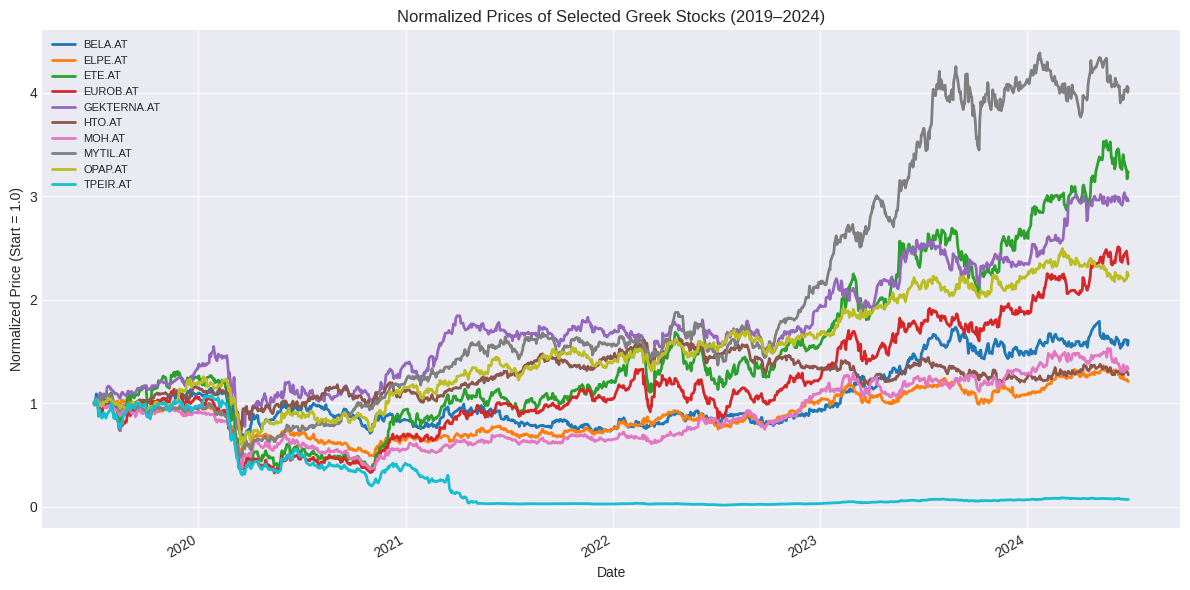

In [3]:
# Install yfinance if needed
!pip install yfinance --upgrade --quiet

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Plotting style
plt.style.use("seaborn-v0_8-darkgrid")

# Updated list (replace ALPHA.AT with GEKTERNA.AT)
tickers = ['HTO.AT', 'EUROB.AT', 'ETE.AT', 'TPEIR.AT',
           'MOH.AT', 'ELPE.AT', 'BELA.AT', 'OPAP.AT', 'MYTIL.AT', 'GEKTERNA.AT']

# Download adjusted close prices
prices = yf.download(tickers, start="2019-07-01", end="2024-07-01")['Close']

# Drop tickers that completely failed
prices = prices.dropna(axis=1, how='all')

# Show which tickers were successfully downloaded
print("✅ Successfully downloaded:", prices.columns.tolist())

# Forward-fill missing values
prices = prices.ffill()

# Normalize prices
normalized_prices = prices / prices.iloc[0]

# Plot
normalized_prices.plot(figsize=(12, 6), lw=2)
plt.title("Normalized Prices of Selected Greek Stocks (2019–2024)")
plt.xlabel("Date")
plt.ylabel("Normalized Price (Start = 1.0)")
plt.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


## 📈 Section 2: Return & Risk Metrics

In this section, we calculate key performance and risk metrics for each asset in our portfolio. These include:

- **Daily & annualized returns**
- **Annualized volatility**
- **Sharpe Ratio** – Measures return per unit of risk.
- **Sortino Ratio** – Like Sharpe but only penalizes downside volatility.
- **Maximum Drawdown** – Largest observed drop from peak to trough.
- **Value at Risk (VaR)** – Estimates the potential loss in worst-case scenarios.
- **Conditional VaR (CVaR)** – Average loss beyond the VaR threshold.

These metrics help evaluate each asset’s risk-return profile and guide future portfolio construction.


In [4]:
# Compute daily returns
returns = prices.pct_change().dropna()

# Set annualization factor
trading_days = 252

# Define metrics
annualized_return = returns.mean() * trading_days
annualized_volatility = returns.std() * np.sqrt(trading_days)

sharpe_ratio = annualized_return / annualized_volatility

# Sortino Ratio (downside deviation)
downside_returns = returns[returns < 0]
downside_std = downside_returns.std() * np.sqrt(trading_days)
sortino_ratio = annualized_return / downside_std

# Max Drawdown
def max_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

max_drawdowns = returns.apply(max_drawdown)

# Historical Value at Risk (VaR) at 95% confidence
VaR_95 = returns.quantile(0.05)

# Conditional VaR (CVaR) — average of returns beyond the 5% quantile
CVaR_95 = returns[returns.le(VaR_95)].mean()

# Combine into a DataFrame
metrics_df = pd.DataFrame({
    'Ann. Return': annualized_return,
    'Ann. Volatility': annualized_volatility,
    'Sharpe Ratio': sharpe_ratio,
    'Sortino Ratio': sortino_ratio,
    'Max Drawdown': max_drawdowns,
    'VaR 95%': VaR_95,
    'CVaR 95%': CVaR_95
}).round(4)

# Display
import pandas.io.formats.style
metrics_df.style.background_gradient(cmap='RdYlGn', axis=0)


,Ann. Return,Ann. Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,VaR 95%,CVaR 95%
Ticker,,,,,,,
BELA.AT,0.160800,0.360600,0.446000,0.691700,-0.468100,-0.031700,-0.048100
ELPE.AT,0.087500,0.313400,0.279200,0.404900,-0.534400,-0.027500,-0.042000
ETE.AT,0.379100,0.530400,0.714700,0.953100,-0.732400,-0.047500,-0.075900
EUROB.AT,0.287600,0.480100,0.599000,0.821600,-0.712700,-0.042300,-0.070100
GEKTERNA.AT,0.291200,0.373800,0.779200,0.976900,-0.567000,-0.028300,-0.050700
HTO.AT,0.085300,0.267700,0.318800,0.450400,-0.359500,-0.024700,-0.036600
MOH.AT,0.128900,0.376400,0.342500,0.512800,-0.647600,-0.033000,-0.049100
MYTIL.AT,0.337600,0.326500,1.033900,1.423800,-0.555500,-0.029600,-0.045700
OPAP.AT,0.212900,0.313600,0.679100,0.869000,-0.524400,-0.024700,-0.043600


## ⚖️ Section 3: Markowitz Portfolio Optimization

In this section, we apply Modern Portfolio Theory to identify the **Minimum Variance Portfolio** — the portfolio with the lowest possible volatility for a given universe of assets.

We impose the following constraints:
- **No short-selling**: All weights ≥ 0
- **Fully invested**: Weights sum to 1

We'll use historical returns and the covariance matrix of asset returns, then apply numerical optimization (`scipy.optimize`) to compute the optimal asset weights.


In [5]:
from scipy.optimize import minimize

# Mean and covariance of returns
mu = returns.mean() * trading_days
cov = returns.cov() * trading_days
n_assets = len(mu)

# Objective: Portfolio variance
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(weights.T @ cov_matrix @ weights)

# Constraints: weights sum to 1, weights >= 0
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(n_assets))
initial_guess = np.array(n_assets * [1/n_assets])

# Minimize portfolio volatility
opt_result = minimize(portfolio_volatility,
                      x0=initial_guess,
                      args=(cov,),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)

# Extract optimal weights
min_var_weights = opt_result.x
min_var_portfolio = pd.Series(min_var_weights, index=mu.index)

# Display
print("Minimum Variance Portfolio Weights:")
display(min_var_portfolio.round(4))

# Portfolio performance
min_vol = portfolio_volatility(min_var_weights, cov)
min_return = np.dot(min_var_weights, mu)

print(f"\nExpected Return: {min_return:.2%}")
print(f"Expected Volatility: {min_vol:.2%}")


Minimum Variance Portfolio Weights:


,0
Ticker,
BELA.AT,0.1121
ELPE.AT,0.2004
ETE.AT,0.0000
EUROB.AT,0.0000
GEKTERNA.AT,0.0000
HTO.AT,0.4422
MOH.AT,0.0155
MYTIL.AT,0.0489
OPAP.AT,0.1809



Expected Return: 13.03%
Expected Volatility: 22.48%


### 🎯 F Portfolio: Target 20% Return

In addition to the minimum variance portfolio, we construct a portfolio that targets an expected annual return of **20%**, while still minimizing risk.

This involves solving a constrained optimization problem:
- **Objective**: Minimize portfolio volatility
- **Constraints**:
  - No short-selling (weights ≥ 0)
  - Fully invested (weights sum to 1)
  - Target expected return = 20% annually

This represents an aggressive portfolio (if feasible), allowing us to compare risk-return trade-offs.


In [6]:
# Set target return
target_return = 0.20  # 20%

# New constraints: weights sum to 1, expected return = target, no shorting
constraints_f = (
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
    {'type': 'eq', 'fun': lambda w: np.dot(w, mu) - target_return}
)

# Same bounds and initial guess
bounds = tuple((0, 1) for _ in range(n_assets))

# Optimization for F Portfolio
f_result = minimize(portfolio_volatility,
                    x0=initial_guess,
                    args=(cov,),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints_f)

# Check feasibility
if f_result.success:
    f_weights = f_result.x
    f_portfolio = pd.Series(f_weights, index=mu.index)

    print("✅ F Portfolio (Target 20% Return) Weights:")
    display(f_portfolio.round(4))

    f_return = np.dot(f_weights, mu)
    f_vol = portfolio_volatility(f_weights, cov)

    print(f"\nExpected Return: {f_return:.2%}")
    print(f"Expected Volatility: {f_vol:.2%}")
else:
    print("❌ Optimization failed — target return may be too high for these assets.")


✅ F Portfolio (Target 20% Return) Weights:


,0
Ticker,
BELA.AT,0.0913
ELPE.AT,0.0510
ETE.AT,0.0000
EUROB.AT,0.0000
GEKTERNA.AT,0.0574
HTO.AT,0.3131
MOH.AT,0.0000
MYTIL.AT,0.2701
OPAP.AT,0.2170



Expected Return: 20.00%
Expected Volatility: 23.52%


## 📊 Section 4: Portfolio Visualization

In this section, we visualize:

- **Asset allocation** of the Minimum Variance Portfolio and the F Portfolio (target 20% return)
- The **Efficient Frontier**, representing the best possible risk-return combinations from many random portfolios
- Our two optimized portfolios marked on the frontier

These plots help us understand trade-offs and diversification visually.


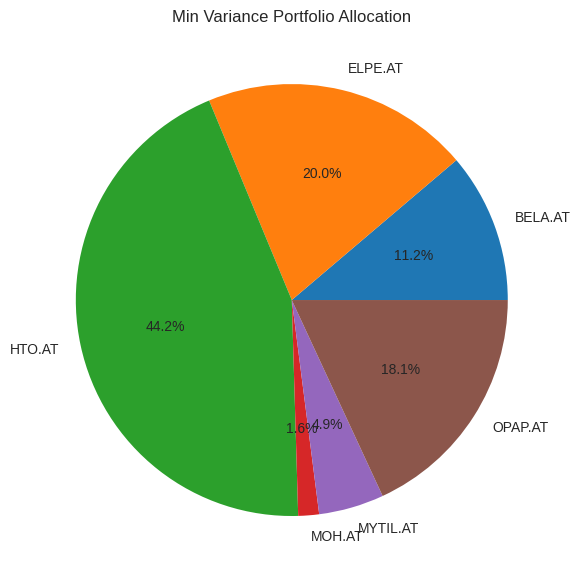

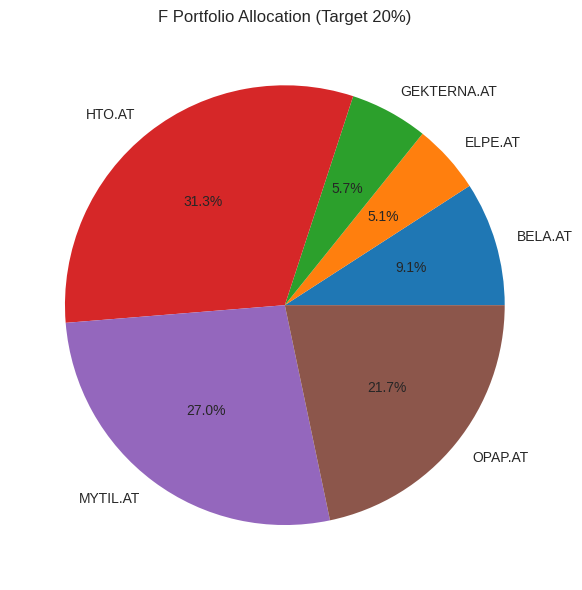

In [8]:
# Pie chart of Min Variance Portfolio
min_var_portfolio[min_var_portfolio > 0.01].plot.pie(
    figsize=(6,6), autopct='%1.1f%%', title='Min Variance Portfolio Allocation')
plt.ylabel("")
plt.tight_layout()
plt.show()

# Pie chart of F Portfolio (only if it succeeded)
if 'f_portfolio' in locals():
    f_portfolio[f_portfolio > 0.01].plot.pie(
        figsize=(6,6), autopct='%1.1f%%', title='F Portfolio Allocation (Target 20%)')
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


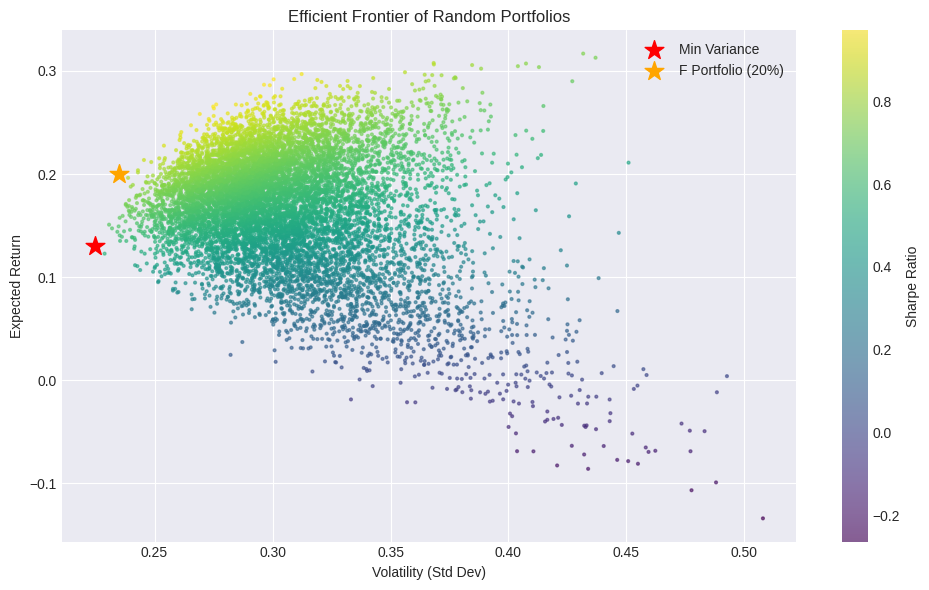

In [9]:
# Generate many random portfolios
n_portfolios = 10_000
results = np.zeros((n_portfolios, 3))  # return, volatility, sharpe
weights_list = []

for i in range(n_portfolios):
    weights = np.random.dirichlet(np.ones(n_assets))  # sum to 1, no shorting
    ret = np.dot(weights, mu)
    vol = np.sqrt(weights @ cov @ weights)
    sharpe = ret / vol
    results[i] = [ret, vol, sharpe]
    weights_list.append(weights)

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=['Return', 'Volatility', 'Sharpe'])

# Plot efficient frontier
plt.figure(figsize=(10,6))
plt.scatter(results_df['Volatility'], results_df['Return'],
            c=results_df['Sharpe'], cmap='viridis', alpha=0.6, s=4)
plt.colorbar(label='Sharpe Ratio')

# Mark Min Var portfolio
plt.scatter(min_vol, min_return, color='red', marker='*', s=200, label='Min Variance')

# Mark F Portfolio
if 'f_result' in locals() and f_result.success:
    plt.scatter(f_vol, f_return, color='orange', marker='*', s=200, label='F Portfolio (20%)')

plt.xlabel('Volatility (Std Dev)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier of Random Portfolios')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔁 Section 6: Backtesting (Train/Test Split)

Now that we’ve constructed optimized portfolios, we want to test whether they perform well **out-of-sample**.

We split the data into:
- **Training set (2019–2022)**: used to calculate optimal portfolio weights
- **Testing set (2023–2024)**: used to simulate actual performance

This allows us to answer: *"Would our strategy have held up in the real world?"*

We backtest both:
- The **Minimum Variance Portfolio**
- The **F Portfolio** targeting a 20% return (if feasible)

We evaluate out-of-sample performance using cumulative return plots and key metrics.


In [10]:
# Split prices
train_prices = prices.loc[:'2022-12-31']
test_prices = prices.loc['2023-01-01':]

# Compute returns
train_returns = train_prices.pct_change().dropna()
test_returns = test_prices.pct_change().dropna()

# Show split confirmation
print(f"Training set: {train_returns.index[0].date()} to {train_returns.index[-1].date()}")
print(f"Testing set: {test_returns.index[0].date()} to {test_returns.index[-1].date()}")


Training set: 2019-07-02 to 2022-12-30
Testing set: 2023-01-03 to 2024-06-28


In [11]:
# Recalculate mean and cov on training set
mu_train = train_returns.mean() * trading_days
cov_train = train_returns.cov() * trading_days
n_assets = len(mu_train)

# Optimization (same constraints)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(n_assets))
initial_guess = np.array(n_assets * [1/n_assets])

train_min_var_result = minimize(portfolio_volatility,
                                x0=initial_guess,
                                args=(cov_train,),
                                method='SLSQP',
                                bounds=bounds,
                                constraints=constraints)

train_min_var_weights = train_min_var_result.x


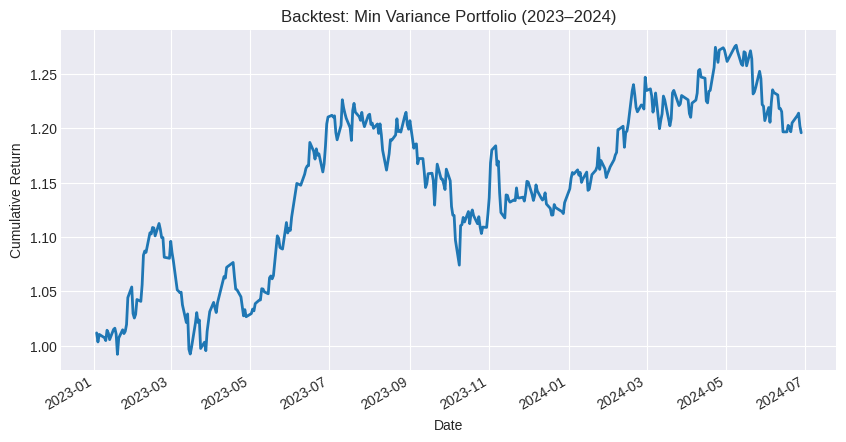

Out-of-Sample Annualized Return: 13.53%
Out-of-Sample Volatility: 16.01%
Sharpe Ratio: 0.85


In [12]:
# Apply weights to test returns
test_portfolio_returns = test_returns @ train_min_var_weights
cumulative_returns = (1 + test_portfolio_returns).cumprod()

# Plot performance
cumulative_returns.plot(figsize=(10, 5), title='Backtest: Min Variance Portfolio (2023–2024)', lw=2)
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

# Metrics
ann_return = test_portfolio_returns.mean() * trading_days
ann_vol = test_portfolio_returns.std() * np.sqrt(trading_days)
sharpe = ann_return / ann_vol
print(f"Out-of-Sample Annualized Return: {ann_return:.2%}")
print(f"Out-of-Sample Volatility: {ann_vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")


### 📊 Backtest: F Portfolio (Target 20% Return)

We now test the performance of the F Portfolio — optimized to target an expected return of 20% annually — using the **training set (2019–2022)** and evaluating its performance on the **test set (2023–2024)**.

This allows us to compare its real-world performance vs. the Min Variance Portfolio, and assess the trade-off between risk and return.


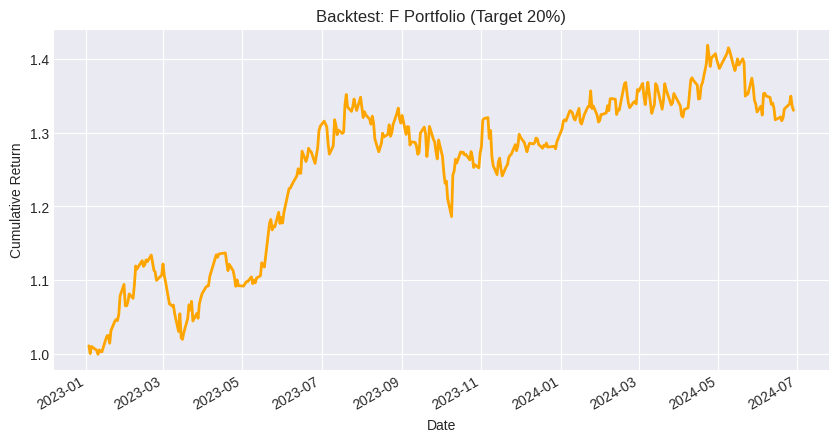

Out-of-Sample Annualized Return: 21.06%
Out-of-Sample Volatility: 17.47%
Sharpe Ratio: 1.21


In [13]:
# Set target return
target_return = 0.20

# Define constraints for F Portfolio
constraints_f = (
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
    {'type': 'eq', 'fun': lambda w: np.dot(w, mu_train) - target_return}
)

# Optimize
train_f_result = minimize(portfolio_volatility,
                          x0=initial_guess,
                          args=(cov_train,),
                          method='SLSQP',
                          bounds=bounds,
                          constraints=constraints_f)

# Check if it succeeded
if train_f_result.success:
    train_f_weights = train_f_result.x

    # Apply to test set
    test_f_returns = test_returns @ train_f_weights
    test_f_cumulative = (1 + test_f_returns).cumprod()

    # Plot
    test_f_cumulative.plot(figsize=(10, 5), title='Backtest: F Portfolio (Target 20%)', lw=2, color='orange')
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.show()

    # Metrics
    f_ann_return = test_f_returns.mean() * trading_days
    f_ann_vol = test_f_returns.std() * np.sqrt(trading_days)
    f_sharpe = f_ann_return / f_ann_vol

    print(f"Out-of-Sample Annualized Return: {f_ann_return:.2%}")
    print(f"Out-of-Sample Volatility: {f_ann_vol:.2%}")
    print(f"Sharpe Ratio: {f_sharpe:.2f}")
else:
    print("❌ F Portfolio (20% target) could not be optimized on training set — infeasible.")


### 📈 Backtest Comparison: Min Variance vs. F Portfolio

To visually compare the performance of the two optimized portfolios during the test period (2023–2024), we overlay their cumulative returns on a single chart.

This highlights the trade-off between **risk** and **return** in real market conditions.


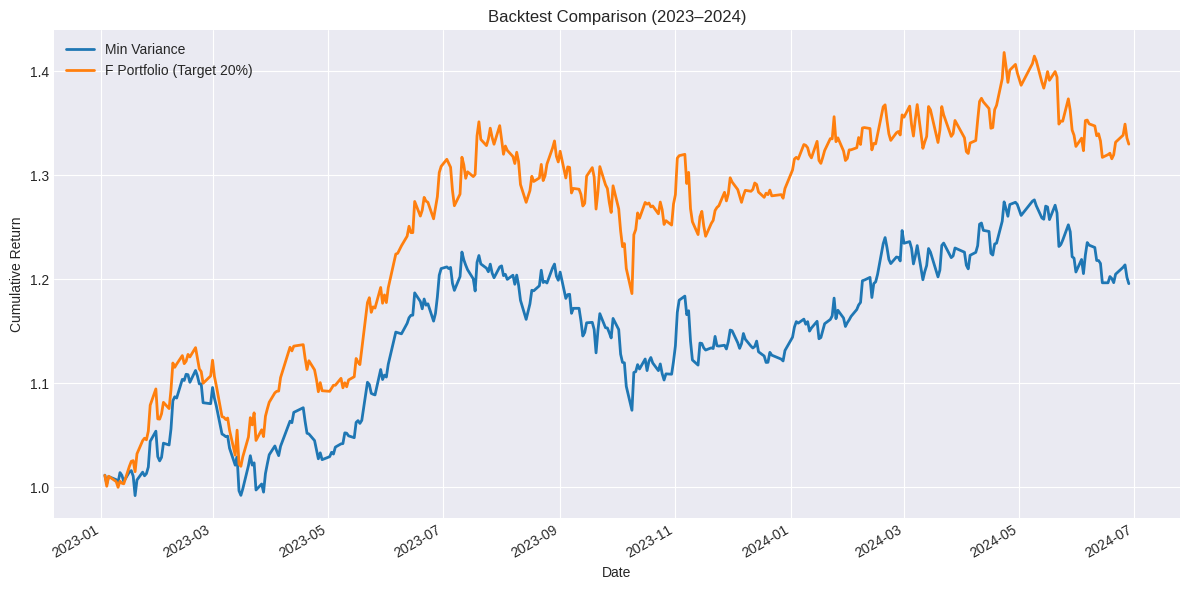

In [14]:
# Combine both cumulative return series
combined = pd.DataFrame({
    'Min Variance': cumulative_returns,
    'F Portfolio (Target 20%)': test_f_cumulative if 'test_f_cumulative' in locals() else np.nan
})

# Drop any rows with missing values (in case F failed)
combined = combined.dropna()

# Plot
combined.plot(figsize=(12, 6), lw=2)
plt.title("Backtest Comparison (2023–2024)")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
